In [1]:
greater_than_cohort_year = 2020
selected_org_id = 'acde6195-7320-4093-910d-07f280e11a19'

In [2]:
import psycopg2
from pandas import read_sql
from datetime import datetime
import pandas as pd

config = { 'dbname': 'dev', 
           'user':'webmaster',
           'pwd':'r2dayIsthegr8ests',
           'host':'zeemee-data-2.crs75grffmt0.us-west-2.redshift.amazonaws.com',
           'port':'5439'
         }

def create_conn(*args,**kwargs):
    config = kwargs['config']
    try:
        con=psycopg2.connect(dbname=config['dbname'], host=config['host'], 
                              port=config['port'], user=config['user'], 
                              password=config['pwd'])
        return con
    except Exception as err:
        print(err)
        
con = create_conn(config=config)

In [3]:
pd.set_option('display.max_columns', 999)

In [4]:
##new touchpoint query 
print(datetime.now().strftime("%H:%M:%S"))

df2 = read_sql("""

select u.id, u.name as user_name, u.email, u.phone_number, o.name as org_name, 
u.type as user_type, 

Case when u.employee = 'TRUE' then 't' else 'f' end as employee, 

Case when u.public_profile_enabled = 'TRUE' then 't' else 'f' end as public_profile_enabled, 

uos.going, 

Case when uos.interested = 'TRUE' then 't' else 'f' end as interested, 

Case when uos.accepted = 'TRUE' then 't' else 'f' end as accepted, 

date(u.created_at) as user_created_at, 
date(uos.created_at) as uos_created_at, uos.start_term, uos.cohort_year, uos.ceeb_code, 


Case when uos.created_by_csv= 'TRUE' then 't' else 'f' end as created_by_csv, 

date(uos.matched_at) as matched_at, date(uos.organic_at) as organic_at, 
date(u.last_sign_in_at) as last_login, 

(
select count(*) from prod_follower.user_organization_statuses uosf 
where uosf.user_id = u.id 
and uosf.organization_id not in ('007e2c79-9118-4a22-8084-ec7a14ab08aa', 
'2b9c0e4b-d8df-4e1c-9abc-6a0b3ffddcbb')

) as total_schools_followed_by_our_user,

(
select count(*) from 
prod_follower.user_follows uf2
where 
uf2.user_uuid = u.uuid
and uf2.following_type = 'Organization'
and uf2.following_uuid not in ('007e2c79-9118-4a22-8084-ec7a14ab08aa', 
'2b9c0e4b-d8df-4e1c-9abc-6a0b3ffddcbb')
) as current_schools_followed_by_our_user_interested_is_True,

(
select count(*) from 
prod_follower.user_follows uf2
where 
uf2.user_uuid = u.uuid and 
uf2.user_type = 'User' and
uf2.following_type = 'User'
) as total_users_followed_by_our_user,

(
select count(uf3.user_uuid) from 
prod_follower.user_follows uf2, prod_follower.user_follows uf3 
where 
uf2.user_uuid = u.uuid and 
uf2.user_type = 'User' and
uf2.following_type = 'User' and
uf2.following_uuid = uf3.user_uuid and
uf3.following_uuid = o.id 
) as users_following_organization_followed_by_our_user,

(
select count(*) 
from prod_follower.user_follows uf2
where 
uf2.user_type = 'User' 
and uf2.following_uuid = u.uuid 
) as total_users_following_our_user,


(
select count(*) 
from prod_follower.user_follows uf2,prod_follower.user_follows uf3
where 
uf2.user_type = 'User' 
and uf2.following_uuid = u.uuid 
and uf3.user_uuid = uf2.user_uuid
and uf3.following_uuid = o.id
) as users_in_organization_following_our_user,

(select hs.name from prod_follower.organizations hs 
where hs.ceeb = uos.ceeb_code limit 1) as uos_high_school_name, 

(select hs.name from prod_follower.organizations hs 
where hs.id = u.high_school_id limit 1) as user_high_school_name, 

Case when uos.transfer_status= 'TRUE' then 't' else 'f' end as transfer_status, 

(case when (select count(*) from prod_follower.user_roommate_answers ura 
where ura.user_id = u.id) > 0 then 't' else 'f' end) as roommate_match_quiz, 

(
select count(*) from ejabberdproduction_log.group_messages gm, ejabberdproduction.muc_room mr
where mr.network_id = o.id
and mr.name = gm.group_id
and gm.from_id = u.uuid
and gm.message_type = 'text'
) as chat_messages_sent_in_org,

(
select count(*) from ejabberdproduction_log.group_messages gm
where
gm.from_id = u.uuid
and message_type in ('text')
) as total_chat_messages_sent_all_orgs,

(
select COUNT(*) 
from ejabberdproduction_log.group_messages gm,
ejabberdproduction.muc_room mr

where gm.message_type = 'seen_target' 
and gm.from_id = u.uuid 
and mr.network_id = o.id
and mr.name = gm.group_id
) as chat_messages_in_org_viewed,

(
select COUNT(*) 
from ejabberdproduction_log.group_messages gm 
where gm.message_type = 'seen_target' 
and gm.from_id = u.uuid 

) as total_group_chats_in_all_orgs_viewed,


(
select count(gm.from_id)
from ejabberdproduction_log.messages gm
where message_type = 'text'
and gm.from_id = u.uuid
) as personal_chat_messages_sent,

(select count(distinct sa.video_id) 
from prod_follower.story_answer_stats sas, prod_follower.story_answers sa, prod_follower.users usa 
where sas.user_id = u.id 
and sas.event_type = 'Heart' 
and sas.story_answer_id = sa.id 
and sa.user_id = usa.id 
and not usa.official_organization_id is null 
and usa.official_organization_id = o.id) as videos_liked, 

(select count(*) from 
prod_follower.story_answer_stats sas, prod_follower.story_answers sa, prod_follower.users usa 
where sas.user_id = u.id 
and sas.event_type = 'View' 
and sas.story_answer_id = sa.id 
and sa.user_id = usa.id 
and not usa.official_organization_id is null 
and usa.official_organization_id = o.id) as videos_viewed, 

(select count(distinct sa.video_id) 
from prod_follower.story_answer_stats sas, prod_follower.story_answers sa, prod_follower.users usa 
where sas.user_id = u.id 
and sas.event_type = 'View' 
and sas.story_answer_id = sa.id 
and sa.user_id = usa.id 
and not usa.official_organization_id is null 
and usa.official_organization_id = o.id) as videos_viewed_unique,

(
select count(*) from prod_follower.story_answers sa, 
prod_follower.users usa where sa.user_id = usa.id 
and not usa.official_organization_id is null 
and usa.official_organization_id = o.id
and sa.created_at > '2019-09-01'
) as official_org_videos_after_1stSpet,


(select count(*) from prod_follower.story_answers sa, 
prod_follower.users usa where sa.user_id = usa.id 
and not usa.official_organization_id is null 
and usa.official_organization_id = o.id
) as total_official_org_videos,


(
select max(sas.created_at)::date 
from prod_follower.story_answer_stats sas, prod_follower.story_answers sa, prod_follower.users usa 
where sas.user_id = u.id
and sas.story_answer_id = sa.id 
and sa.user_id = usa.id  
and usa.official_organization_id = o.id
) as videos_last_engaged,

(
select max(ura.created_at)::date from prod_follower.user_roommate_answers ura 
where ura.user_id = u.id 
) as room_mate_match_last_engaged,

(select max(gm.created_at)::date
from ejabberdproduction_log.group_messages gm, ejabberdproduction.muc_room mr
where gm.from_id = u.uuid 
and gm.group_id = mr.name 
and mr.network_id = o.id
) as messages_last_engaged





from prod_follower.users u, 
prod_follower.user_organization_statuses uos, 
prod_follower.organizations o 

where u.id = uos.user_id 
and u.type = 'Student' 
and u.employee = false 
and not u.email ilike '%@zeemee.com' 
and uos.organization_id = o.id 
and o.id = '""" + selected_org_id 
               +"""' and u.official_organization_id is null 

order by o.name, u.name """, con=con)
print(datetime.now().strftime("%H:%M:%S"))

13:44:54
13:45:11


In [5]:
df2.head(3)

,id,user_name,email,phone_number,org_name,user_type,employee,public_profile_enabled,going,interested,accepted,user_created_at,uos_created_at,start_term,cohort_year,ceeb_code,created_by_csv,matched_at,organic_at,last_login,total_schools_followed_by_our_user,current_schools_followed_by_our_user_interested_is_true,total_users_followed_by_our_user,users_following_organization_followed_by_our_user,total_users_following_our_user,users_in_organization_following_our_user,uos_high_school_name,user_high_school_name,transfer_status,roommate_match_quiz,chat_messages_sent_in_org,total_chat_messages_sent_all_orgs,chat_messages_in_org_viewed,total_group_chats_in_all_orgs_viewed,personal_chat_messages_sent,videos_liked,videos_viewed,videos_viewed_unique,official_org_videos_after_1stspet,total_official_org_videos,videos_last_engaged,room_mate_match_last_engaged,messages_last_engaged
0,64703,(Mary) Palen McDermott,palenmcdermott@gmail.com,None,University of Denver,Student,f,t,undecided,t,f,2016-10-02,2016-10-04,Fall,2017,None,f,None,2016-10-04,2016-12-19,4,3,0,0,0,0,None,None,f,f,0,0,0,0,0,0,0,0,2,51,None,None,None
1,952804,-,,+16512697308,University of Denver,Student,f,f,undecided,t,f,2019-11-27,2019-11-27,Fall,2020,Rosemount,t,2019-11-27,None,2019-11-27,5,4,0,0,0,0,None,None,f,f,0,0,0,10,0,0,0,0,2,51,None,None,None
2,782988,.,alyswiley@gmail.com,+17015096792,University of Denver,Student,f,t,undecided,t,f,2018-08-09,2019-06-20,Fall,2019,None,t,2019-06-20,None,2018-08-09,3,3,0,0,0,0,None,None,f,f,0,0,0,0,0,0,0,0,2,51,None,None,None


In [10]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [12]:
a= df2.chat_messages_sent_in_org.rank(pct=True)
b= df2.total_chat_messages_sent_all_orgs.rank(pct=True)
c= df2.chat_messages_in_org_viewed.rank(pct=True)
d= df2.total_group_chats_in_all_orgs_viewed.rank(pct=True)
e= df2.personal_chat_messages_sent.rank(pct=True)
f= df2.videos_liked.rank(pct=True)
g= df2.videos_viewed.rank(pct=True)
h= df2.videos_viewed_unique.rank(pct=True)


df2['a'] = a
df2['b'] = b
df2['c'] = c
df2['d'] = d
df2['e'] = e
df2['f'] = f
df2['g'] = g
df2['h'] = h


In [14]:
df2['avg'] = df2[['a','b', 'c', 'd', 'e', 'f', 'g', 'h']].mean(axis=1)

In [32]:
a,b,c,d

(0        0.464751
 1        0.464751
 2        0.464751
 3        0.464751
 4        0.464751
            ...   
 23613    0.464751
 23614    0.464751
 23615    0.464751
 23616    0.464751
 23617    0.464751
 Name: chat_messages_sent_in_org, Length: 23618, dtype: float64,
 0        0.425904
 1        0.425904
 2        0.425904
 3        0.425904
 4        0.425904
            ...   
 23613    0.425904
 23614    0.425904
 23615    0.425904
 23616    0.867220
 23617    0.425904
 Name: total_chat_messages_sent_all_orgs, Length: 23618, dtype: float64,
 0        0.45658
 1        0.45658
 2        0.45658
 3        0.45658
 4        0.45658
           ...   
 23613    0.45658
 23614    0.45658
 23615    0.45658
 23616    0.45658
 23617    0.45658
 Name: chat_messages_in_org_viewed, Length: 23618, dtype: float64,
 0        0.437399
 1        0.932170
 2        0.437399
 3        0.437399
 4        0.437399
            ...   
 23613    0.437399
 23614    0.437399
 23615    0.437399
 23616  

In [15]:
import matplotlib.pyplot as plt


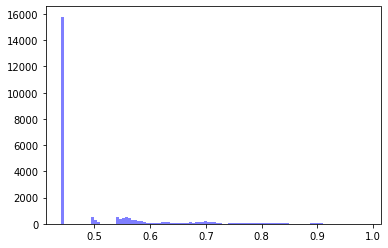

In [17]:
num_bins = 100
n, bins, patches = plt.hist(df2['avg'], num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [61]:
z= len(df2[df2['avg'] > 0.8])
y= len(df2[(df2['avg'] <= 0.8) & (df2['avg'] > 0.6)])
x= len(df2[(df2['avg'] <= 0.6) & (df2['avg'] > 0.4)])
w= len(df2[(df2['avg'] < 0.4)])
v= len(df2)

In [64]:
x/v

0.8582437124227285

In [72]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

trial_scaler = min_max_scaler.fit_transform(df2[['avg']].values.astype(float))

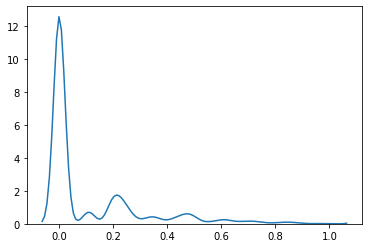

In [73]:
sns.distplot(trial_scaler , hist=False, rug=False)

In [88]:
z= len([x for x in trial_scaler if x >= 0.6])
y= len([x for x in trial_scaler if x < 0.6 and x>=0.2])
#x= len([x for x in trial_scaler if x >= 0.4 and x<0.6])
w= len([x for x in trial_scaler if x <0.2])
v= len(df2)

In [91]:
y/v

0.211999322550597

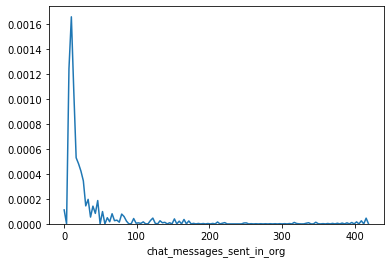

In [71]:
import seaborn as sns

#sns.distplot(df2['avg'], hist=False, rug=False)
sns.distplot(df2['chat_messages_sent_in_org'], hist=False, rug=False)

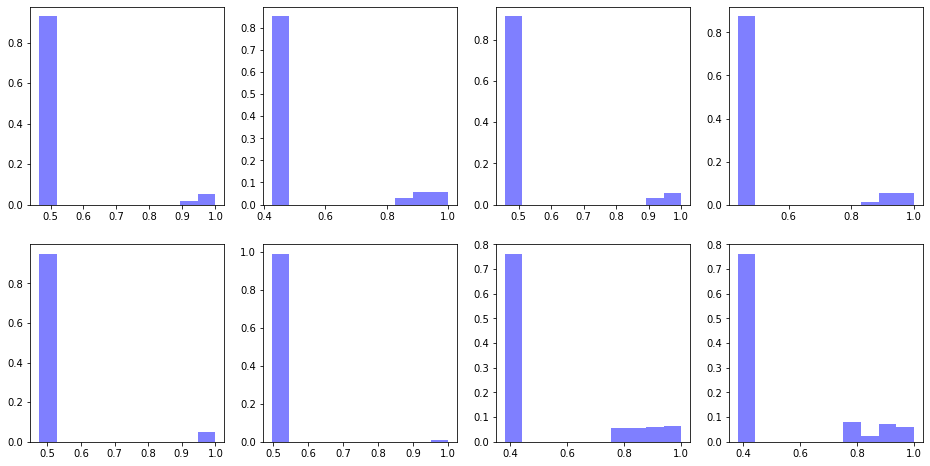

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

ax00 = axes[0][0]
ax00.hist(a, bins=10, weights=np.ones(len(a)) / len(a),
        color='blue', alpha=0.5, label='1')

ax01 = axes[0][1]
ax01.hist(b, bins=10, weights=np.ones(len(b)) / len(b),
        color='blue', alpha=0.5, label='2')

ax02 = axes[0][2]
ax02.hist(c, bins=10, weights=np.ones(len(c)) / len(c),
        color='blue', alpha=0.5, label='2')

ax12 = axes[0][3]
ax12.hist(d, bins=10, weights=np.ones(len(d)) / len(d), 
        color='blue', alpha=0.5, label='2')

ax10 = axes[1][0]
ax10.hist(e, bins=10, weights=np.ones(len(e)) / len(e), 
        color='blue', alpha=0.5, label='2')

ax11 = axes[1][1]
ax11.hist(f, bins=10, weights=np.ones(len(f)) / len(f),
        color='blue', alpha=0.5, label='2')

ax12 = axes[1][2]
ax12.hist(g,bins=10, weights=np.ones(len(g)) / len(g),
        color='blue', alpha=0.5, label='2')

ax12 = axes[1][3]
ax12.hist(h,bins=10, weights=np.ones(len(h)) / len(h),
        color='blue', alpha=0.5, label='2')

plt.show()

In [46]:
df2.head(3)

,id,user_name,email,phone_number,org_name,user_type,employee,public_profile_enabled,going,interested,accepted,user_created_at,uos_created_at,start_term,cohort_year,ceeb_code,created_by_csv,matched_at,organic_at,last_login,total_schools_followed_by_our_user,current_schools_followed_by_our_user_interested_is_true,total_users_followed_by_our_user,users_following_organization_followed_by_our_user,total_users_following_our_user,users_in_organization_following_our_user,uos_high_school_name,user_high_school_name,transfer_status,roommate_match_quiz,chat_messages_sent_in_org,total_chat_messages_sent_all_orgs,chat_messages_in_org_viewed,total_group_chats_in_all_orgs_viewed,personal_chat_messages_sent,videos_liked,videos_viewed,videos_viewed_unique,official_org_videos_after_1stspet,total_official_org_videos,videos_last_engaged,room_mate_match_last_engaged,messages_last_engaged,a,b,c,d,e,f,g,h,avg
0,64703,(Mary) Palen McDermott,palenmcdermott@gmail.com,None,University of Denver,Student,f,t,undecided,t,f,2016-10-02,2016-10-04,Fall,2017,None,f,None,2016-10-04,2016-12-19,4,3,0,0,0,0,None,None,f,f,0,0,0,0,0,0,0,0,2,51,None,None,None,0.464751,0.425904,0.45658,0.437399,0.474892,0.496253,0.381319,0.381319,0.439802
1,952804,-,,+16512697308,University of Denver,Student,f,f,undecided,t,f,2019-11-27,2019-11-27,Fall,2020,Rosemount,t,2019-11-27,None,2019-11-27,5,4,0,0,0,0,None,None,f,f,0,0,0,10,0,0,0,0,2,51,None,None,None,0.464751,0.425904,0.45658,0.932170,0.474892,0.496253,0.381319,0.381319,0.501649
2,782988,.,alyswiley@gmail.com,+17015096792,University of Denver,Student,f,t,undecided,t,f,2018-08-09,2019-06-20,Fall,2019,None,t,2019-06-20,None,2018-08-09,3,3,0,0,0,0,None,None,f,f,0,0,0,0,0,0,0,0,2,51,None,None,None,0.464751,0.425904,0.45658,0.437399,0.474892,0.496253,0.381319,0.381319,0.439802


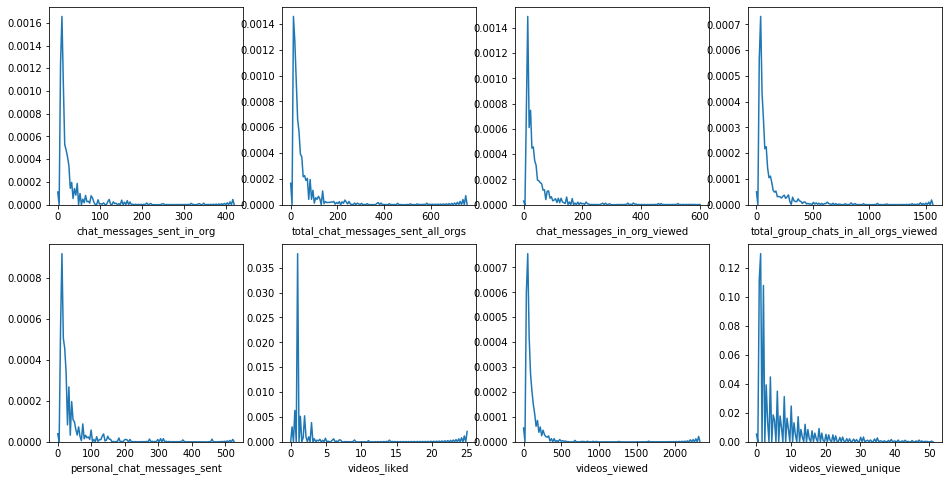

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

sns.distplot(df2['chat_messages_sent_in_org'], hist=False, rug=False, ax = axes[0][0])

sns.distplot(df2['total_chat_messages_sent_all_orgs'], hist=False, rug=False, ax = axes[0][1])

sns.distplot(df2['chat_messages_in_org_viewed'], hist=False, rug=False, ax = axes[0][2])

sns.distplot(df2['total_group_chats_in_all_orgs_viewed'], hist=False, rug=False, ax = axes[0][3])

sns.distplot(df2['personal_chat_messages_sent'], hist=False, rug=False, ax = axes[1][0])

sns.distplot(df2['videos_liked'], hist=False, rug=False, ax = axes[1][1])

sns.distplot(df2['videos_viewed'], hist=False, rug=False, ax = axes[1][2])

sns.distplot(df2['videos_viewed_unique'], hist=False, rug=False, ax = axes[1][3])

plt.show()

In [49]:
n1= df2[(df2['chat_messages_sent_in_org']<40)]['chat_messages_sent_in_org']
n2 = df2[(df2['total_chat_messages_sent_all_orgs']<40)]['total_chat_messages_sent_all_orgs']
n3 = df2[(df2['chat_messages_in_org_viewed']<40)]['chat_messages_in_org_viewed']
n4 = df2[(df2['total_group_chats_in_all_orgs_viewed']<40)]['total_group_chats_in_all_orgs_viewed']
n5 = df2[(df2['personal_chat_messages_sent']<40)]['personal_chat_messages_sent']
n6 = df2[(df2['videos_liked']<40)]['videos_liked']
n7 = df2[(df2['videos_viewed']<40)]['videos_viewed']
n8 = df2[(df2['videos_viewed_unique']<40)]['videos_viewed_unique']

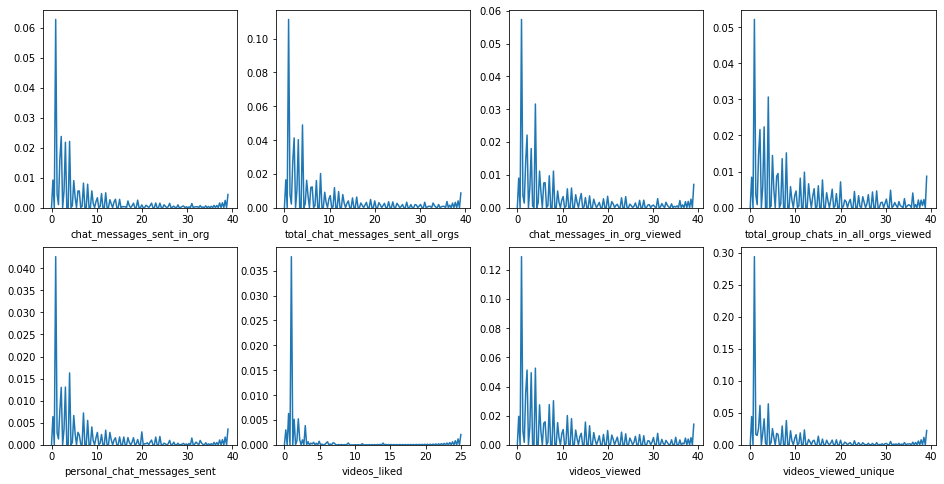

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

sns.distplot(n1, hist=False, rug=False, ax = axes[0][0])

sns.distplot(n2, hist=False, rug=False, ax = axes[0][1])

sns.distplot(n3, hist=False, rug=False, ax = axes[0][2])

sns.distplot(n4, hist=False, rug=False, ax = axes[0][3])

sns.distplot(n5, hist=False, rug=False, ax = axes[1][0])

sns.distplot(n6, hist=False, rug=False, ax = axes[1][1])

sns.distplot(n7, hist=False, rug=False, ax = axes[1][2])

sns.distplot(n8, hist=False, rug=False, ax = axes[1][3])

plt.show()

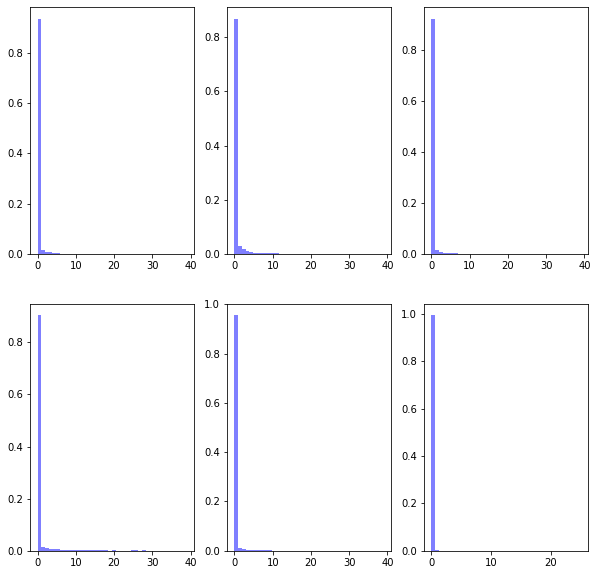

In [117]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
ax00 = axes[0][0]
ax00.hist(n1, bins=40, weights=np.ones(len(n1)) / len(n1),
        color='blue', alpha=0.5, label='1')

ax01 = axes[0][1]
ax01.hist(n2, bins=40, weights=np.ones(len(n2)) / len(n2),
        color='blue', alpha=0.5, label='2')

ax02 = axes[0][2]
ax02.hist(n3, bins=40, weights=np.ones(len(n3)) / len(n3),
        color='blue', alpha=0.5, label='2')

ax10 = axes[1][0]
ax10.hist(n4, bins=40, weights=np.ones(len(n4)) / len(n4),
        color='blue', alpha=0.5, label='2')

ax11 = axes[1][1]
ax11.hist(n5, bins=40, weights=np.ones(len(n5)) / len(n5),
        color='blue', alpha=0.5, label='2')

ax12 = axes[1][2]
ax12.hist(n6, bins=40, weights=np.ones(len(n6)) / len(n6),
        color='blue', alpha=0.5, label='2')

plt.show()

In [72]:
def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

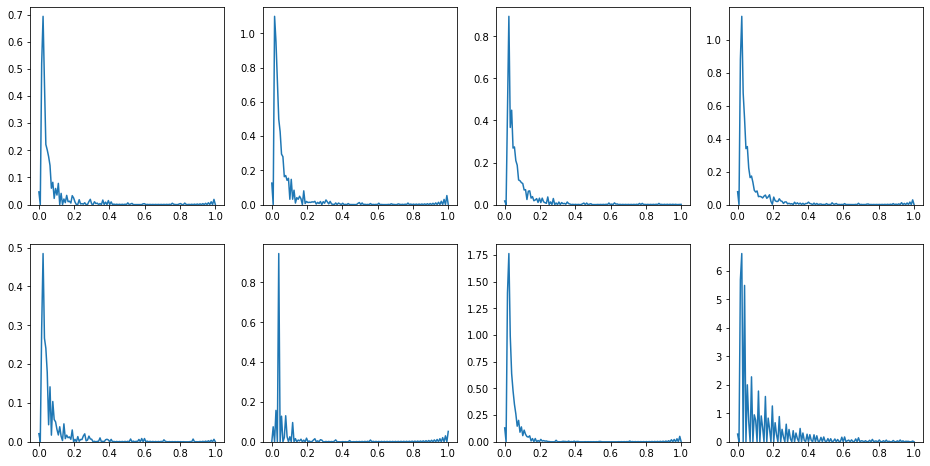

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

sns.distplot(MinMaxScaler().fit_transform(df2[['chat_messages_sent_in_org']].values.astype(float)),
             hist=False, rug=False, ax = axes[0][0])

sns.distplot(MinMaxScaler().fit_transform(df2[['total_chat_messages_sent_all_orgs']].values.astype(float)),
             hist=False, rug=False, ax = axes[0][1])

sns.distplot(MinMaxScaler().fit_transform(df2[['chat_messages_in_org_viewed']].values.astype(float)),
             hist=False, rug=False, ax = axes[0][2])

sns.distplot(MinMaxScaler().fit_transform(df2[['total_group_chats_in_all_orgs_viewed']].values.astype(float)),
             hist=False, rug=False, ax = axes[0][3])

sns.distplot(MinMaxScaler().fit_transform(df2[['personal_chat_messages_sent']].values.astype(float)),
             hist=False, rug=False, ax = axes[1][0])

sns.distplot(MinMaxScaler().fit_transform(df2[['videos_liked']].values.astype(float)),
             hist=False, rug=False, ax = axes[1][1])

sns.distplot(MinMaxScaler().fit_transform(df2[['videos_viewed']].values.astype(float)),
             hist=False, rug=False, ax = axes[1][2])

sns.distplot(MinMaxScaler().fit_transform(df2[['videos_viewed_unique']].values.astype(float)),
             hist=False, rug=False, ax = axes[1][3])

plt.show()

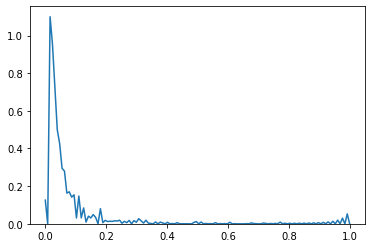

In [99]:
sns.distplot(MinMaxScaler().fit_transform(df2[['total_chat_messages_sent_all_orgs']].values.astype(float)),
             hist=False, kde = True, rug=False)

(array([9.41612330e-01, 2.26522144e-02, 8.38343636e-03, 6.43576933e-03,
        4.02235583e-03, 3.47192819e-03, 1.94766703e-03, 1.86298586e-03,
        1.48192057e-03, 1.27021763e-03, 8.04471166e-04, 8.89152341e-04,
        6.35108815e-04, 3.38724701e-04, 2.96384114e-04, 3.81065289e-04,
        2.96384114e-04, 2.54043526e-04, 4.65746465e-04, 1.27021763e-04,
        1.27021763e-04, 8.46811754e-05, 2.11702938e-04, 1.69362351e-04,
        1.27021763e-04, 4.23405877e-05, 1.27021763e-04, 1.27021763e-04,
        0.00000000e+00, 1.27021763e-04, 2.54043526e-04, 1.27021763e-04,
        8.46811754e-05, 1.27021763e-04, 0.00000000e+00, 0.00000000e+00,
        4.23405877e-05, 4.23405877e-05, 4.23405877e-05, 0.00000000e+00,
        4.23405877e-05, 0.00000000e+00, 0.00000000e+00, 4.23405877e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.27021763e-04, 0.00000000e+00, 4.23405877e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.234058

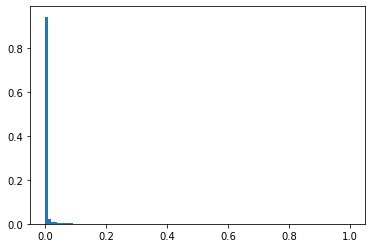

In [102]:
tt = MinMaxScaler().fit_transform(df2[['total_chat_messages_sent_all_orgs']].values.astype(float))

plt.hist(tt, bins = 100,  weights=np.ones(len(tt)) / len(tt))

In [103]:
df2.head(3)

,id,user_name,email,phone_number,org_name,user_type,employee,public_profile_enabled,going,interested,accepted,user_created_at,uos_created_at,start_term,cohort_year,ceeb_code,created_by_csv,matched_at,organic_at,last_login,total_schools_followed_by_our_user,current_schools_followed_by_our_user_interested_is_true,total_users_followed_by_our_user,users_following_organization_followed_by_our_user,total_users_following_our_user,users_in_organization_following_our_user,uos_high_school_name,user_high_school_name,transfer_status,roommate_match_quiz,chat_messages_sent_in_org,total_chat_messages_sent_all_orgs,chat_messages_in_org_viewed,total_group_chats_in_all_orgs_viewed,personal_chat_messages_sent,videos_liked,videos_viewed,videos_viewed_unique,official_org_videos_after_1stspet,total_official_org_videos,videos_last_engaged,room_mate_match_last_engaged,messages_last_engaged,a,b,c,d,e,f,g,h,avg
0,64703,(Mary) Palen McDermott,palenmcdermott@gmail.com,None,University of Denver,Student,f,t,undecided,t,f,2016-10-02,2016-10-04,Fall,2017,None,f,None,2016-10-04,2016-12-19,4,3,0,0,0,0,None,None,f,f,0,0,0,0,0,0,0,0,2,51,None,None,None,0.464751,0.425904,0.45658,0.437399,0.474892,0.496253,0.381319,0.381319,0.439802
1,952804,-,,+16512697308,University of Denver,Student,f,f,undecided,t,f,2019-11-27,2019-11-27,Fall,2020,Rosemount,t,2019-11-27,None,2019-11-27,5,4,0,0,0,0,None,None,f,f,0,0,0,10,0,0,0,0,2,51,None,None,None,0.464751,0.425904,0.45658,0.932170,0.474892,0.496253,0.381319,0.381319,0.501649
2,782988,.,alyswiley@gmail.com,+17015096792,University of Denver,Student,f,t,undecided,t,f,2018-08-09,2019-06-20,Fall,2019,None,t,2019-06-20,None,2018-08-09,3,3,0,0,0,0,None,None,f,f,0,0,0,0,0,0,0,0,2,51,None,None,None,0.464751,0.425904,0.45658,0.437399,0.474892,0.496253,0.381319,0.381319,0.439802


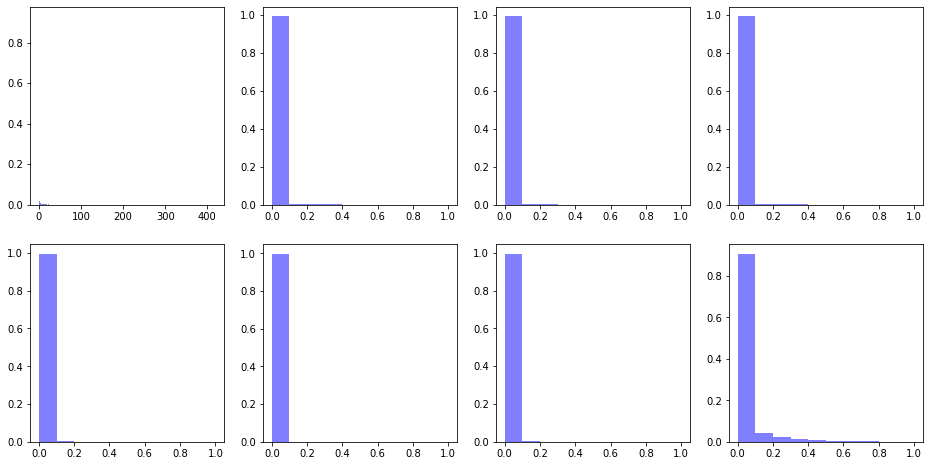

In [255]:

at= MinMaxScaler().fit_transform(df2[['chat_messages_sent_in_org']].values.astype(float))
bt= MinMaxScaler().fit_transform(df2[['total_chat_messages_sent_all_orgs']].values.astype(float))
ct= MinMaxScaler().fit_transform(df2[['chat_messages_in_org_viewed']].values.astype(float))
dt= MinMaxScaler().fit_transform(df2[['total_group_chats_in_all_orgs_viewed']].values.astype(float))
et= MinMaxScaler().fit_transform(df2[['personal_chat_messages_sent']].values.astype(float))
ft= MinMaxScaler().fit_transform(df2[['videos_liked']].values.astype(float))
gt= MinMaxScaler().fit_transform(df2[['videos_viewed']].values.astype(float))
ht= MinMaxScaler().fit_transform(df2[['videos_viewed_unique']].values.astype(float))



fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

ax00 = axes[0][0]
ax00.hist(df2['chat_messages_sent_in_org'], bins=max(df2['chat_messages_sent_in_org']), 
          weights=np.ones(len(
    df2['chat_messages_sent_in_org'])) / len(df2['chat_messages_sent_in_org']),
        color='blue', alpha=0.5, label='1')

ax01 = axes[0][1]
ax01.hist(bt, bins=10, weights=np.ones(len(bt)) / len(bt),
        color='blue', alpha=0.5, label='2')

ax02 = axes[0][2]
ax02.hist(ct, bins=10, weights=np.ones(len(ct)) / len(ct),
        color='blue', alpha=0.5, label='2')

ax12 = axes[0][3]
ax12.hist(dt, bins=10, weights=np.ones(len(dt)) / len(dt), 
        color='blue', alpha=0.5, label='2')

ax10 = axes[1][0]
ax10.hist(et, bins=10, weights=np.ones(len(et)) / len(et), 
        color='blue', alpha=0.5, label='2')

ax11 = axes[1][1]
ax11.hist(ft, bins=10, weights=np.ones(len(ft)) / len(ft),
        color='blue', alpha=0.5, label='2')

ax12 = axes[1][2]
ax12.hist(gt,bins=10, weights=np.ones(len(gt)) / len(gt),
        color='blue', alpha=0.5, label='2')

ax12 = axes[1][3]
ax12.hist(ht,bins=10, weights=np.ones(len(ht)) / len(ht),
        color='blue', alpha=0.5, label='2')

plt.show()

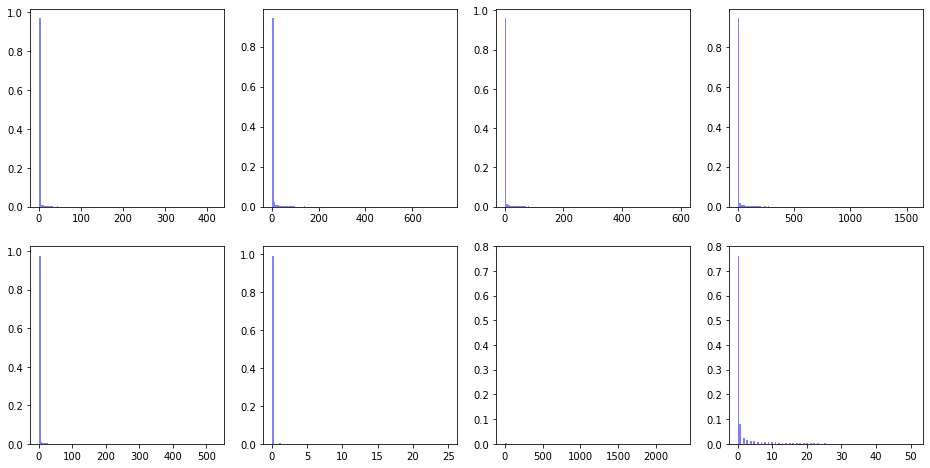

In [11]:
######-------#######-------


#plot these

at= df2['chat_messages_sent_in_org']
bt=df2['total_chat_messages_sent_all_orgs']
ct= df2['chat_messages_in_org_viewed']
dt= df2['total_group_chats_in_all_orgs_viewed']
et= df2['personal_chat_messages_sent']
ft= df2['videos_liked']
gt= df2['videos_viewed']
ht= df2['videos_viewed_unique']



fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

ax00 = axes[0][0]
ax00.hist(at, bins=100, 
          weights=np.ones(len(at)) / len(at),
        color='blue', alpha=0.5, label='1')

ax01 = axes[0][1]
ax01.hist(bt, bins=100, weights=np.ones(len(bt)) / len(bt),
        color='blue', alpha=0.5, label='2')

ax02 = axes[0][2]
ax02.hist(ct, bins=100, weights=np.ones(len(ct)) / len(ct),
        color='blue', alpha=0.5, label='2')

ax12 = axes[0][3]
ax12.hist(dt, bins=100, weights=np.ones(len(dt)) / len(dt), 
        color='blue', alpha=0.5, label='2')

ax10 = axes[1][0]
ax10.hist(et, bins=100, weights=np.ones(len(et)) / len(et), 
        color='blue', alpha=0.5, label='2')

ax11 = axes[1][1]
ax11.hist(ft, bins=100, weights=np.ones(len(ft)) / len(ft),
        color='blue', alpha=0.5, label='2')

ax12 = axes[1][2]
ax12.hist(gt,bins=max(gt), weights=np.ones(len(gt)) / len(gt),
        color='blue', alpha=0.5, label='2')

ax12 = axes[1][3]
ax12.hist(ht,bins=100, weights=np.ones(len(ht)) / len(ht),
        color='blue', alpha=0.5, label='2')

plt.show()

In [14]:
n1= df2[(df2['chat_messages_sent_in_org']<410) & 
       (df2['chat_messages_sent_in_org']>0)]['chat_messages_sent_in_org']
n2 = df2[(df2['total_chat_messages_sent_all_orgs']<410) &
        (df2['total_chat_messages_sent_all_orgs']>0)]['total_chat_messages_sent_all_orgs']
n3 = df2[(df2['chat_messages_in_org_viewed']<410) &
        (df2['chat_messages_in_org_viewed']>0)]['chat_messages_in_org_viewed']
n4 = df2[(df2['total_group_chats_in_all_orgs_viewed']<410) &
        (df2['total_group_chats_in_all_orgs_viewed']>0)]['total_group_chats_in_all_orgs_viewed']
n5 = df2[(df2['personal_chat_messages_sent']<410) &
        (df2['personal_chat_messages_sent']>0)]['personal_chat_messages_sent']
n6 = df2[(df2['videos_liked']<410) &
        (df2['videos_liked']>0)]['videos_liked']
n7 = df2[(df2['videos_viewed']<410) &
        (df2['videos_viewed']>0)]['videos_viewed']
n8 = df2[(df2['videos_viewed_unique']<410) &
        (df2['videos_viewed_unique']>0)]['videos_viewed_unique']

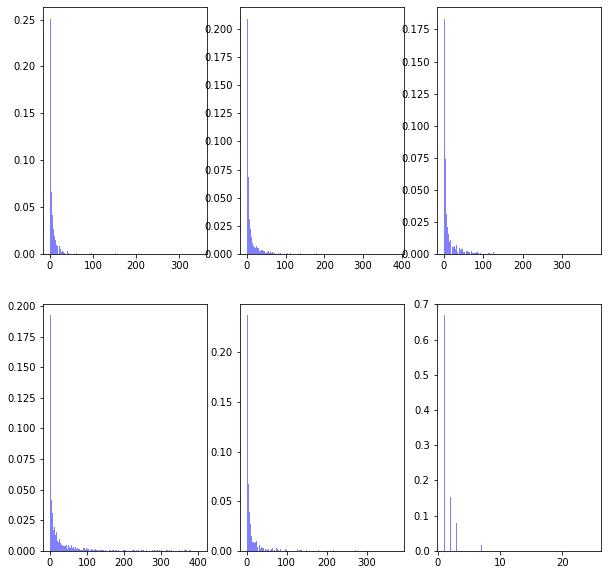

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
ax00 = axes[0][0]
ax00.hist(n1, bins=400, weights=np.ones(len(n1)) / len(n1),
        color='blue', alpha=0.5, label='1')

ax01 = axes[0][1]
ax01.hist(n2, bins=400, weights=np.ones(len(n2)) / len(n2),
        color='blue', alpha=0.5, label='2')

ax02 = axes[0][2]
ax02.hist(n3, bins=400, weights=np.ones(len(n3)) / len(n3),
        color='blue', alpha=0.5, label='2')

ax10 = axes[1][0]
ax10.hist(n4, bins=400, weights=np.ones(len(n4)) / len(n4),
        color='blue', alpha=0.5, label='2')

ax11 = axes[1][1]
ax11.hist(n5, bins=400, weights=np.ones(len(n5)) / len(n5),
        color='blue', alpha=0.5, label='2')

ax12 = axes[1][2]
ax12.hist(n6, bins=400, weights=np.ones(len(n6)) / len(n6),
        color='blue', alpha=0.5, label='2')

plt.show()

In [17]:
##convert each interaction column into 0-100 scale
##find average of those scaled columns
##plot the graph

at= MinMaxScaler().fit_transform(df2[['chat_messages_sent_in_org']].values.astype(float))
bt= MinMaxScaler().fit_transform(df2[['total_chat_messages_sent_all_orgs']].values.astype(float))
ct= MinMaxScaler().fit_transform(df2[['chat_messages_in_org_viewed']].values.astype(float))
dt= MinMaxScaler().fit_transform(df2[['total_group_chats_in_all_orgs_viewed']].values.astype(float))
et= MinMaxScaler().fit_transform(df2[['personal_chat_messages_sent']].values.astype(float))
ft= MinMaxScaler().fit_transform(df2[['videos_liked']].values.astype(float))
gt= MinMaxScaler().fit_transform(df2[['videos_viewed']].values.astype(float))
ht= MinMaxScaler().fit_transform(df2[['videos_viewed_unique']].values.astype(float))


In [18]:
df2['a'] = at
df2['b'] = bt
df2['c'] = ct
df2['d'] = dt
df2['e'] = et
df2['f'] = ft
df2['g'] = gt
df2['h'] = ht
df2['avg'] = df2[['a','b', 'c', 'd', 'e', 'f', 'g', 'h']].mean(axis=1)

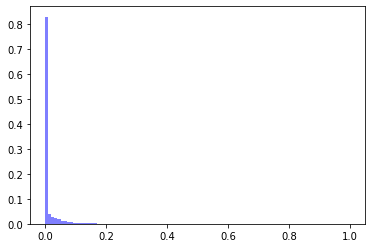

In [21]:
avg = MinMaxScaler().fit_transform(df2[['avg']].values.astype(float))

plt.hist(avg, bins=100, weights=np.ones(len(avg)) / len(avg),
        color='blue', alpha=0.5, label='2')
plt.show()

In [23]:
from sklearn.cluster import KMeans

#df2[['chat_messages_sent_in_org','total_chat_messages_sent_all_orgs',
 #               'chat_messages_in_org_viewed', 'total_group_chats_in_all_orgs_viewed',
  #              'personal_chat_messages_sent', 'videos_liked',
   #             'videos_viewed', 'videos_viewed_unique'
    #           ]]

In [24]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=600, n_init=10, random_state=0)
kmeans.fit(df2[['a','b','c','d', 'e', 'f', 'g', 'h']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df2[['a','b','c','d', 'e', 'f', 'g', 'h']])

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

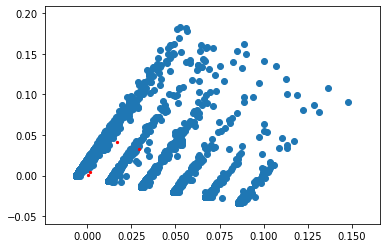

In [39]:
pred_y = kmeans.predict(df2[['a','b','c','d', 'e', 'f', 'g', 'h']])
plt.scatter(principalDf['pc1'], principalDf['pc2'])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=5, c='red')
plt.show()

In [40]:
df2['y'] = pred_y

In [41]:
group = df2.groupby('y')['chat_messages_sent_in_org','total_chat_messages_sent_all_orgs',
                'chat_messages_in_org_viewed', 'total_group_chats_in_all_orgs_viewed',
                'personal_chat_messages_sent', 'videos_liked',
                'videos_viewed', 'videos_viewed_unique'
               ].mean()

group

,chat_messages_sent_in_org,total_chat_messages_sent_all_orgs,chat_messages_in_org_viewed,total_group_chats_in_all_orgs_viewed,personal_chat_messages_sent,videos_liked,videos_viewed,videos_viewed_unique
y,,,,,,,,
0,0.060280,0.493620,0.221672,1.101674,0.112138,0.001786,0.419508,0.094069
1,40.103448,93.103448,27.758621,68.241379,205.241379,0.068966,90.758621,11.137931
2,2.242738,5.622376,3.060109,5.268910,2.275237,0.080817,47.594766,10.222318
3,16.821154,55.182692,43.513462,170.946154,5.371154,0.071154,13.025000,1.667308


In [42]:
from collections import Counter

Counter(pred_y)

#y= 0 passive users (21.3k) (90.25%)
#y= 1 low active users (1738) (7.35%)
#y= 2 moderate active users (439) (1.85%)
#y= 3 very active users (125) (0.53%)

Counter({0: 19592, 2: 3477, 3: 520, 1: 29})

In [43]:
group.sort_values(by = 'chat_messages_sent_in_org')

,chat_messages_sent_in_org,total_chat_messages_sent_all_orgs,chat_messages_in_org_viewed,total_group_chats_in_all_orgs_viewed,personal_chat_messages_sent,videos_liked,videos_viewed,videos_viewed_unique
y,,,,,,,,
0,0.060280,0.493620,0.221672,1.101674,0.112138,0.001786,0.419508,0.094069
2,2.242738,5.622376,3.060109,5.268910,2.275237,0.080817,47.594766,10.222318
3,16.821154,55.182692,43.513462,170.946154,5.371154,0.071154,13.025000,1.667308
1,40.103448,93.103448,27.758621,68.241379,205.241379,0.068966,90.758621,11.137931


In [44]:
len(df2)

23618

In [45]:
ddd= df2[df2['y'] == 0]
len(ddd)

19592

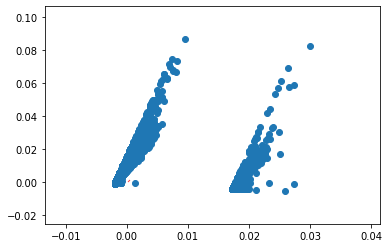

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,chat_messages_sent_in_org,total_chat_messages_sent_all_orgs,chat_messages_in_org_viewed,total_group_chats_in_all_orgs_viewed,personal_chat_messages_sent,videos_liked,videos_viewed,videos_viewed_unique
y,,,,,,,,
0,0.051327,0.457547,0.178264,1.007888,0.091949,0.000676,0.000000,0.0
1,0.146500,0.841020,0.639718,2.004883,0.306565,0.012480,4.459577,1.0


In [52]:
kmeans1 = KMeans(n_clusters=2, init='k-means++', max_iter=600, n_init=10, random_state=0)
kmeans1.fit(ddd[['a','b','c','d', 'e', 'f', 'g', 'h']])

pca1 = PCA(n_components=2)
principalComponents = pca1.fit_transform(ddd[['a','b','c','d', 'e', 'f', 'g', 'h']])

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

pred_y = kmeans1.predict(ddd[['a','b','c','d', 'e', 'f', 'g', 'h']])
plt.scatter(principalDf['pc1'], principalDf['pc2'])
plt.scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1], s=0.11, c='red')
plt.show()

ddd['y'] = pred_y

group = ddd.groupby('y')['chat_messages_sent_in_org','total_chat_messages_sent_all_orgs',
                'chat_messages_in_org_viewed', 'total_group_chats_in_all_orgs_viewed',
                'personal_chat_messages_sent', 'videos_liked',
                'videos_viewed', 'videos_viewed_unique'
               ].mean()

group

In [50]:
Counter(pred_y) 

#total y = 0 in 1st clstering = 21.3k
# y= 0 low in every thing - very passive users (19.6k)(82.59%)
# y= 1 in general high chats - very low msg views (7) (0.03%)
# y= 2 not very active, nor very passive (1339) (5.67%)
# y= 3 active users, passive in couple of categories like videos liked and personal 
# message sent (378)(1.6%)

Counter({0: 17749, 1: 1843})

In [64]:
kmeans1 = KMeans(n_clusters=2, init='k-means++', max_iter=600, n_init=10, random_state=0)
kmeans1.fit(principalDf[['pc1','pc2']])
pred_y1 = kmeans1.predict(principalDf[['pc1','pc2']])

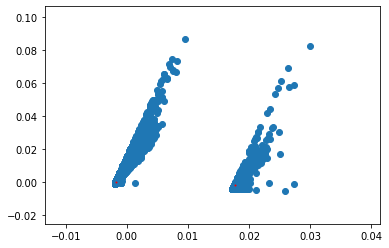

In [65]:
plt.scatter(principalDf['pc1'], principalDf['pc2'])
plt.scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1], s=1, c='red')
plt.show()

In [66]:
len(principalDf['pc1'])

19592

In [67]:
ddd['y1'] = pred_y1

group = ddd.groupby('y1')['chat_messages_sent_in_org','total_chat_messages_sent_all_orgs',
                'chat_messages_in_org_viewed', 'total_group_chats_in_all_orgs_viewed',
                'personal_chat_messages_sent', 'videos_liked',
                'videos_viewed', 'videos_viewed_unique'
               ].mean()

group

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,chat_messages_sent_in_org,total_chat_messages_sent_all_orgs,chat_messages_in_org_viewed,total_group_chats_in_all_orgs_viewed,personal_chat_messages_sent,videos_liked,videos_viewed,videos_viewed_unique
y1,,,,,,,,
0,0.051327,0.457547,0.178264,1.007888,0.091949,0.000676,0.000000,0.0
1,0.146500,0.841020,0.639718,2.004883,0.306565,0.012480,4.459577,1.0


In [68]:
Counter(pred_y1) 

Counter({0: 17749, 1: 1843})

In [275]:
ddd1 = df2.copy(deep = True)

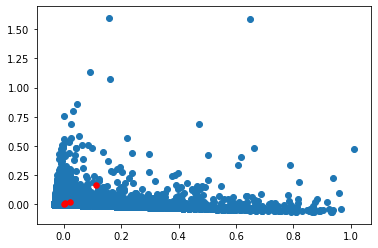

,chat_messages_sent_in_org,total_chat_messages_sent_all_orgs,chat_messages_in_org_viewed,total_group_chats_in_all_orgs_viewed,personal_chat_messages_sent,videos_liked,videos_viewed,videos_viewed_unique
y,,,,,,,,
0,0.219272,1.241415,0.746153,3.125633,0.296491,0.003894,1.236817,0.302074
1,2.333142,7.305524,3.087457,5.891830,3.342348,0.095512,49.780783,10.833142
2,9.724374,12.676538,10.027335,15.205011,10.031891,0.191344,153.435080,29.569476
3,47.128000,127.128000,101.936000,377.872000,18.560000,0.176000,22.960000,2.624000


In [276]:
principalComponents = pca.transform(ddd1[['a','b','c','d', 'e', 'f', 'g', 'h']])

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

pred_y = kmeans.fit_predict(ddd1[['a','b','c','d', 'e', 'f', 'g', 'h']])
plt.scatter(principalDf['pc1'], principalDf['pc2'])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=30, c='red')
plt.show()

ddd1['y'] = pred_y

group = ddd1.groupby('y')['chat_messages_sent_in_org','total_chat_messages_sent_all_orgs',
                'chat_messages_in_org_viewed', 'total_group_chats_in_all_orgs_viewed',
                'personal_chat_messages_sent', 'videos_liked',
                'videos_viewed', 'videos_viewed_unique'
               ].mean()

group